# Plot effective kernel of our filters

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

In [2]:
import gcm_filters # use branch https://github.com/gustavo-marques/gcm-filters/tree/anisotropic_kappas

In [3]:
list(gcm_filters.GridType)

[<GridType.CARTESIAN: 1>,
 <GridType.CARTESIAN_WITH_LAND: 2>,
 <GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>]

In [4]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND)

['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

## Open POP 0.1 degree data

In [5]:
ds = xr.open_dataset('/glade/work/igrooms/current_data', decode_times=False)

### Make ocean ("wet") mask

In [6]:
wet_mask = xr.where(ds['KMT']>0,1,0)

Text(0.5, 1.0, 'wet_mask')

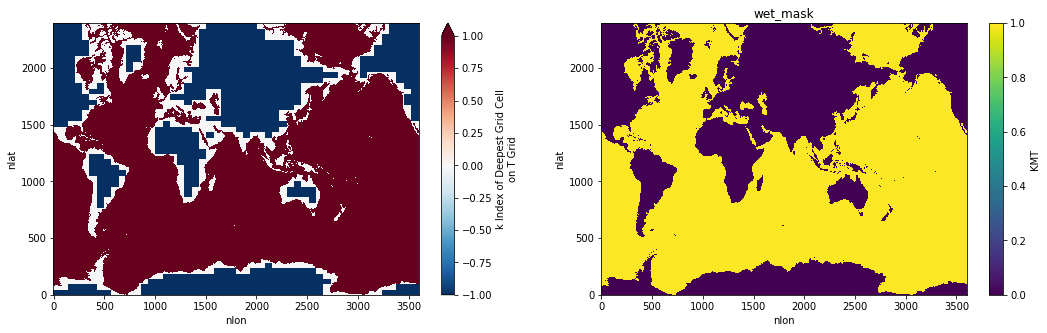

In [7]:
fig,axs = plt.subplots(1,2,figsize=(18,5))
ds.KMT.plot(ax=axs[0],vmin=ds.KMT.min())
wet_mask.plot(ax=axs[1])
axs[1].set_title('wet_mask')

### Create remaining grid info required by `IRREGULAR_CARTESIAN_WITH_LAND` Laplacian 

In [8]:
# grid spacings in m
HUS = ds.HUS.where(wet_mask)/100 
HTE = ds.HTE.where(wet_mask)/100 
HTN = ds.HTN.where(wet_mask)/100 
HUW = ds.HUW.where(wet_mask)/100 
TAREA = ds.TAREA.where(wet_mask)/10000

dxw = HUS.roll(nlon=-1, roll_coords=False)  # x-spacing centered at western T-cell edge
dyw = HTE.roll(nlon=-1, roll_coords=False)  # y-spacing centered at western T-cell edge
dxs = HTN.roll(nlat=-1, roll_coords=False)  # x-spacing centered at southern T-cell edge
dys = HUW.roll(nlat=-1, roll_coords=False)  # y-spacing centered at southern T-cell edge in m
tarea = TAREA  # cell area

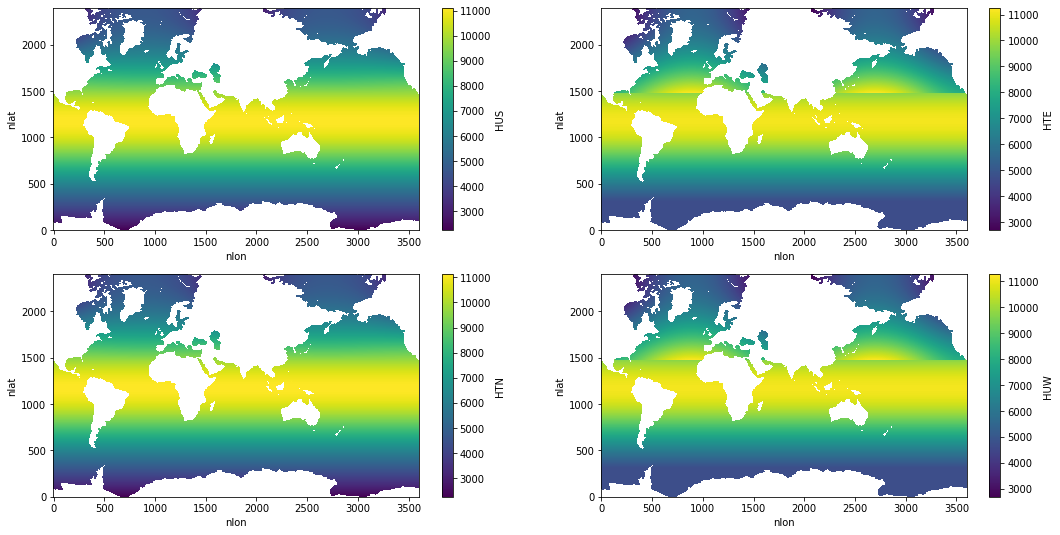

In [9]:
fig,axs = plt.subplots(2,2,figsize=(18,9))
dxw.plot(ax=axs[0,0])
dyw.plot(ax=axs[0,1])
dxs.plot(ax=axs[1,0])
dys.plot(ax=axs[1,1])

In [10]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values
dx_min

array(2245.78304344)

# Define spatial filters

In [11]:
filter_scale = 111700

We will test 
* two different filter shapes: Gaussian and Taper
* two sets of kappa: one set defining isotropic filtering, one set defining anisotropic filtering

### Gaussian

In [12]:
filter_Gaussian_isotropic = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0, 
    grid_type=gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': tarea, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': xr.ones_like(wet_mask)}
)
filter_Gaussian_isotropic

Filter(filter_scale=111700, dx_min=array(2245.78304344), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=0, grid_type=<GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>)

In [13]:
filter_Gaussian_anisotropic = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0,  
    grid_type=gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': tarea, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': 0.1*xr.ones_like(wet_mask)}
)
filter_Gaussian_anisotropic

Filter(filter_scale=111700, dx_min=array(2245.78304344), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=0, grid_type=<GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>)

### Taper

In [14]:
filter_Taper_isotropic = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=0,  
    grid_type=gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': tarea, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': xr.ones_like(wet_mask)}
)
filter_Taper_isotropic

Filter(filter_scale=111700, dx_min=array(2245.78304344), filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=0, grid_type=<GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>)

In [15]:
filter_Taper_anisotropic = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=0,  
    grid_type=gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': tarea, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': 0.1*xr.ones_like(wet_mask)}
)
filter_Taper_anisotropic

Filter(filter_scale=111700, dx_min=array(2245.78304344), filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=0, grid_type=<GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>)

## Fixed factor

Also test fixed factor.

In [16]:
filter_fixed_factor_Gaussian = gcm_filters.Filter(
    filter_scale=10,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0, 
    grid_type=gcm_filters.GridType.CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter_fixed_factor_Gaussian

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=0, grid_type=<GridType.CARTESIAN_WITH_LAND: 2>)

In [17]:
filter_fixed_factor_Taper = gcm_filters.Filter(
    filter_scale=10,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=0,  
    grid_type=gcm_filters.GridType.CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter_fixed_factor_Taper

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=0, grid_type=<GridType.CARTESIAN_WITH_LAND: 2>)

### Filter delta functions in Gulf Stream region & tropical Pacific

In [18]:
# Gulf Stream
delta1 = 0 * xr.ones_like(ds.nlat*ds.nlon) 
delta1[1643,398] = 1
delta1 = delta1.where(wet_mask)

delta2 = 0 * xr.ones_like(ds.nlat*ds.nlon) 
delta2[1635,440] = 1
delta2 = delta2.where(wet_mask)

delta3 = 0 * xr.ones_like(ds.nlat*ds.nlon) 
delta3[1620,363] = 1
delta3 = delta3.where(wet_mask)

# Tropical Pacific
delta4 = 0 * xr.ones_like(ds.nlat*ds.nlon) 
delta4[1220,250] = 1
delta4 = delta4.where(wet_mask)

delta5 = 0 * xr.ones_like(ds.nlat*ds.nlon) 
delta5[1180,290] = 1
delta5 = delta5.where(wet_mask)

delta6 = 0 * xr.ones_like(ds.nlat*ds.nlon) 
delta6[1250,320] = 1
delta6 = delta6.where(wet_mask)

In [19]:
delta1_filtered_Gaussian_isotropic = filter_Gaussian_isotropic.apply(delta1, dims=['nlat', 'nlon'])
delta2_filtered_Gaussian_isotropic = filter_Gaussian_isotropic.apply(delta2, dims=['nlat', 'nlon'])
delta3_filtered_Gaussian_isotropic = filter_Gaussian_isotropic.apply(delta3, dims=['nlat', 'nlon'])
delta4_filtered_Gaussian_isotropic = filter_Gaussian_isotropic.apply(delta4, dims=['nlat', 'nlon'])
delta5_filtered_Gaussian_isotropic = filter_Gaussian_isotropic.apply(delta5, dims=['nlat', 'nlon'])
delta6_filtered_Gaussian_isotropic = filter_Gaussian_isotropic.apply(delta6, dims=['nlat', 'nlon'])

delta1_filtered_Gaussian_anisotropic = filter_Gaussian_anisotropic.apply(delta1, dims=['nlat', 'nlon'])
delta2_filtered_Gaussian_anisotropic = filter_Gaussian_anisotropic.apply(delta2, dims=['nlat', 'nlon'])
delta3_filtered_Gaussian_anisotropic = filter_Gaussian_anisotropic.apply(delta3, dims=['nlat', 'nlon'])
delta4_filtered_Gaussian_anisotropic = filter_Gaussian_anisotropic.apply(delta4, dims=['nlat', 'nlon'])
delta5_filtered_Gaussian_anisotropic = filter_Gaussian_anisotropic.apply(delta5, dims=['nlat', 'nlon'])
delta6_filtered_Gaussian_anisotropic = filter_Gaussian_anisotropic.apply(delta6, dims=['nlat', 'nlon'])

delta1_filtered_Taper_isotropic = filter_Taper_isotropic.apply(delta1, dims=['nlat', 'nlon'])
delta2_filtered_Taper_isotropic = filter_Taper_isotropic.apply(delta2, dims=['nlat', 'nlon'])
delta3_filtered_Taper_isotropic = filter_Taper_isotropic.apply(delta3, dims=['nlat', 'nlon'])
delta4_filtered_Taper_isotropic = filter_Taper_isotropic.apply(delta4, dims=['nlat', 'nlon'])
delta5_filtered_Taper_isotropic = filter_Taper_isotropic.apply(delta5, dims=['nlat', 'nlon'])
delta6_filtered_Taper_isotropic = filter_Taper_isotropic.apply(delta6, dims=['nlat', 'nlon'])

delta1_filtered_Taper_anisotropic = filter_Taper_anisotropic.apply(delta1, dims=['nlat', 'nlon'])
delta2_filtered_Taper_anisotropic = filter_Taper_anisotropic.apply(delta2, dims=['nlat', 'nlon'])
delta3_filtered_Taper_anisotropic = filter_Taper_anisotropic.apply(delta3, dims=['nlat', 'nlon'])
delta4_filtered_Taper_anisotropic = filter_Taper_anisotropic.apply(delta4, dims=['nlat', 'nlon'])
delta5_filtered_Taper_anisotropic = filter_Taper_anisotropic.apply(delta5, dims=['nlat', 'nlon'])
delta6_filtered_Taper_anisotropic = filter_Taper_anisotropic.apply(delta6, dims=['nlat', 'nlon'])

delta1_filtered_fixed_factor_Gaussian = filter_fixed_factor_Gaussian.apply(delta1*tarea, dims=['nlat', 'nlon'])
delta1_filtered_fixed_factor_Gaussian = delta1_filtered_fixed_factor_Gaussian/tarea
delta2_filtered_fixed_factor_Gaussian = filter_fixed_factor_Gaussian.apply(delta2*tarea, dims=['nlat', 'nlon'])
delta2_filtered_fixed_factor_Gaussian = delta2_filtered_fixed_factor_Gaussian/tarea
delta3_filtered_fixed_factor_Gaussian = filter_fixed_factor_Gaussian.apply(delta3*tarea, dims=['nlat', 'nlon'])
delta3_filtered_fixed_factor_Gaussian = delta3_filtered_fixed_factor_Gaussian/tarea
delta4_filtered_fixed_factor_Gaussian = filter_fixed_factor_Gaussian.apply(delta4*tarea, dims=['nlat', 'nlon'])
delta4_filtered_fixed_factor_Gaussian = delta4_filtered_fixed_factor_Gaussian/tarea
delta5_filtered_fixed_factor_Gaussian = filter_fixed_factor_Gaussian.apply(delta5*tarea, dims=['nlat', 'nlon'])
delta5_filtered_fixed_factor_Gaussian = delta5_filtered_fixed_factor_Gaussian/tarea
delta6_filtered_fixed_factor_Gaussian = filter_fixed_factor_Gaussian.apply(delta6*tarea, dims=['nlat', 'nlon'])
delta6_filtered_fixed_factor_Gaussian = delta6_filtered_fixed_factor_Gaussian/tarea

delta1_filtered_fixed_factor_Taper = filter_fixed_factor_Taper.apply(delta1*tarea, dims=['nlat', 'nlon'])
delta1_filtered_fixed_factor_Taper = delta1_filtered_fixed_factor_Taper/tarea
delta2_filtered_fixed_factor_Taper = filter_fixed_factor_Taper.apply(delta2*tarea, dims=['nlat', 'nlon'])
delta2_filtered_fixed_factor_Taper = delta2_filtered_fixed_factor_Taper/tarea
delta3_filtered_fixed_factor_Taper = filter_fixed_factor_Taper.apply(delta3*tarea, dims=['nlat', 'nlon'])
delta3_filtered_fixed_factor_Taper = delta3_filtered_fixed_factor_Taper/tarea
delta4_filtered_fixed_factor_Taper = filter_fixed_factor_Taper.apply(delta4*tarea, dims=['nlat', 'nlon'])
delta4_filtered_fixed_factor_Taper = delta4_filtered_fixed_factor_Taper/tarea
delta5_filtered_fixed_factor_Taper = filter_fixed_factor_Taper.apply(delta5*tarea, dims=['nlat', 'nlon'])
delta5_filtered_fixed_factor_Taper = delta5_filtered_fixed_factor_Taper/tarea
delta6_filtered_fixed_factor_Taper = filter_fixed_factor_Taper.apply(delta6*tarea, dims=['nlat', 'nlon'])
delta6_filtered_fixed_factor_Taper = delta6_filtered_fixed_factor_Taper/tarea

## Plot effective filter kernels: Gulf Stream region

/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarnin

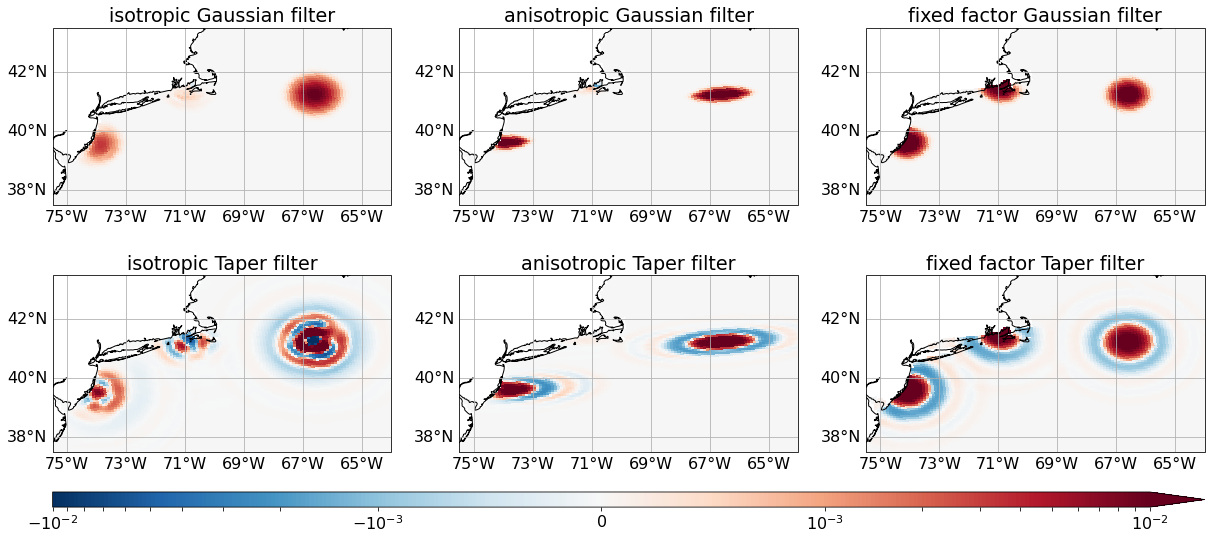

In [20]:
import matplotlib.pylab as pylab
params = {'font.size': 16}
pylab.rcParams.update(params)

# Gulf Stream region
nlon0_gs = 300
nlon1_gs = 500
nlat0_gs = 1550
nlat1_gs = 1700
xslice = slice(nlon0_gs,nlon1_gs)
yslice = slice(nlat0_gs,nlat1_gs)

fig,axs = plt.subplots(2,3,figsize=(20,7),subplot_kw={'projection':ccrs.PlateCarree()})
        
(delta1_filtered_Gaussian_isotropic+delta2_filtered_Gaussian_isotropic+delta3_filtered_Gaussian_isotropic).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0,0],x='ULONG',y='ULAT',
                                                                     vmin=-0.01,vmax=0.01,cmap='RdBu_r',
                                                                     norm=mpl.colors.SymLogNorm(linthresh=0.001),
                                                                     add_colorbar=False,
                                                                     transform=ccrs.PlateCarree())

(delta1_filtered_Gaussian_anisotropic+delta2_filtered_Gaussian_anisotropic+delta3_filtered_Gaussian_anisotropic).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0,1],x='ULONG',y='ULAT',
                                                                                vmin=-0.01,vmax=0.01,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=0.001),
                                                                                 add_colorbar=False,
                                                                                 transform=ccrs.PlateCarree())
                                                                               
(delta1_filtered_Taper_isotropic+delta2_filtered_Taper_isotropic+delta3_filtered_Taper_isotropic).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1,0],x='ULONG',y='ULAT',
                                                                                vmin=-0.01,vmax=0.01,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=0.001),
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())

(delta1_filtered_Taper_anisotropic+delta2_filtered_Taper_anisotropic+delta3_filtered_Taper_anisotropic).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1,1],x='ULONG',y='ULAT',
                                                                                vmin=-0.01,vmax=0.01,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=0.001),
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())

(delta1_filtered_fixed_factor_Gaussian+delta2_filtered_fixed_factor_Gaussian+delta3_filtered_fixed_factor_Gaussian).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0,2],x='ULONG',y='ULAT',
                                                                                vmin=-0.01,vmax=0.01,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=0.001),
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())

p=(delta1_filtered_fixed_factor_Taper+delta2_filtered_fixed_factor_Taper+delta3_filtered_fixed_factor_Taper).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1,2],x='ULONG',y='ULAT',
                                                                                vmin=-0.01,vmax=0.01,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=0.001),
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())


for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent([-75.5, -64, 37.5, 43.5], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-75,-73,-71,-69,-67,-65])
    gl.ylocator = mticker.FixedLocator([38,40,42])
    
axs[0,0].set(title='isotropic Gaussian filter')
axs[0,1].set(title='anisotropic Gaussian filter')
axs[1,0].set(title='isotropic Taper filter')
axs[1,1].set(title='anisotropic Taper filter')
axs[0,2].set(title='fixed factor Gaussian filter')
axs[1,2].set(title='fixed factor Taper filter')
# colorbar
fig.subplots_adjust(left=0.1, bottom=-0.02)
cax = fig.add_axes([0.1, -0.1, 0.8, 0.03])
cbar = fig.colorbar(p, cax=cax, orientation='horizontal',extend='max')
    
plt.savefig('figures/effective_kernel_scale_112km_fac_10_log.png',dpi=400,bbox_inches='tight',pad_inches=0)

There seem to be issues with the "isotropic" Taper kernel (in particular, it does not really have an isotropic shape), whereas the anisotropic Taper kernel looks as expected. If the problem were due to numerical instabilities, the problem would arise for both the isotropic and the anisotropic Taper kernel shapes because they use the same filter specs: `length scale = 112km` and `n_steps = 319`.

Looking at the POP grid spacing (see plot futher up) makes me believe that this is actually not a problem with our filter but with the abrupt shift in `dy` right around `nlat = 1500` (around 40N) in the east Atlantic.

To clear up this question, let's repeat the analysis in the tropical Pacific, where the grid is better behaved. The following plot shows that the problem disappears, so I think the issue was really the grid changes at 40N.

## Plot effective filter kernels: Tropical Pacific

/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  del sys.path[0]
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:37: Matplotli

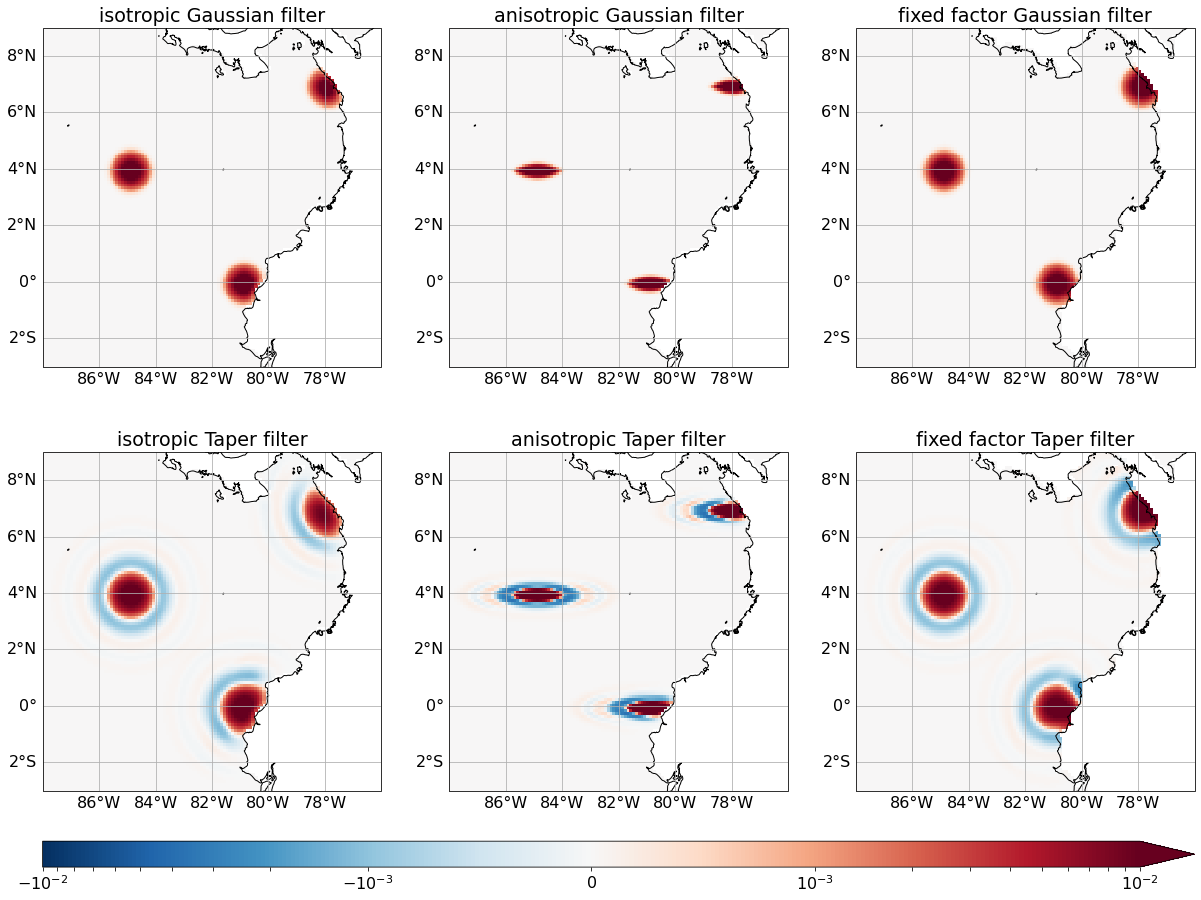

In [21]:
# Tropical Pacific
nlon0_tp = 0
nlon1_tp = 1000
nlat0_tp = 1100
nlat1_tp = 1300
xslice = slice(nlon0_tp,nlon1_tp)
yslice = slice(nlat0_tp,nlat1_tp)

fig,axs = plt.subplots(2,3,figsize=(20,12),subplot_kw={'projection':ccrs.PlateCarree()})
        
(delta4_filtered_Gaussian_isotropic+delta5_filtered_Gaussian_isotropic+delta6_filtered_Gaussian_isotropic).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0,0],x='ULONG',y='ULAT',
                                                                     vmin=-0.01,vmax=0.01,cmap='RdBu_r',
                                                                     norm=mpl.colors.SymLogNorm(linthresh=0.001),
                                                                     add_colorbar=False,
                                                                     transform=ccrs.PlateCarree())

(delta4_filtered_Gaussian_anisotropic+delta5_filtered_Gaussian_anisotropic+delta6_filtered_Gaussian_anisotropic).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0,1],x='ULONG',y='ULAT',
                                                                                vmin=-0.01,vmax=0.01,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=0.001),
                                                                                 add_colorbar=False,
                                                                                 transform=ccrs.PlateCarree())
                                                                               
(delta4_filtered_Taper_isotropic+delta5_filtered_Taper_isotropic+delta6_filtered_Taper_isotropic).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1,0],x='ULONG',y='ULAT',                                                                                                  
                                                                                vmin=-0.01,vmax=0.01,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=0.001),
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())

(delta4_filtered_Taper_anisotropic+delta5_filtered_Taper_anisotropic+delta6_filtered_Taper_anisotropic).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1,1],x='ULONG',y='ULAT',
                                                                                vmin=-0.01,vmax=0.01,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=0.001),
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())

(delta4_filtered_fixed_factor_Gaussian+delta5_filtered_fixed_factor_Gaussian+delta6_filtered_fixed_factor_Gaussian).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0,2],x='ULONG',y='ULAT',
                                                                                vmin=-0.01,vmax=0.01,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=0.001),
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())

p=(delta4_filtered_fixed_factor_Taper+delta5_filtered_fixed_factor_Taper+delta6_filtered_fixed_factor_Taper).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1,2],x='ULONG',y='ULAT',
                                                                                vmin=-0.01,vmax=0.01,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=0.001),
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())


for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent([-88, -76, -3, 9], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-86,-84,-82,-80,-78])
    gl.ylocator = mticker.FixedLocator([-2,0,2,4,6,8])
    
axs[0,0].set(title='isotropic Gaussian filter')
axs[0,1].set(title='anisotropic Gaussian filter')
axs[1,0].set(title='isotropic Taper filter')
axs[1,1].set(title='anisotropic Taper filter')
axs[0,2].set(title='fixed factor Gaussian filter')
axs[1,2].set(title='fixed factor Taper filter')
# colorbar
fig.subplots_adjust(left=0.1, bottom=-0.02)
cax = fig.add_axes([0.1, -0.1, 0.8, 0.03])
cbar = fig.colorbar(p, cax=cax, orientation='horizontal',extend='max')
    
plt.savefig('figures/effective_kernel_scale_112km_fac_10_tropPac_log.png',dpi=400,bbox_inches='tight',pad_inches=0)

The following plot is the same as the previous, but values are divided by local area.

/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  del sys.path[0]
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:37: Matplotli

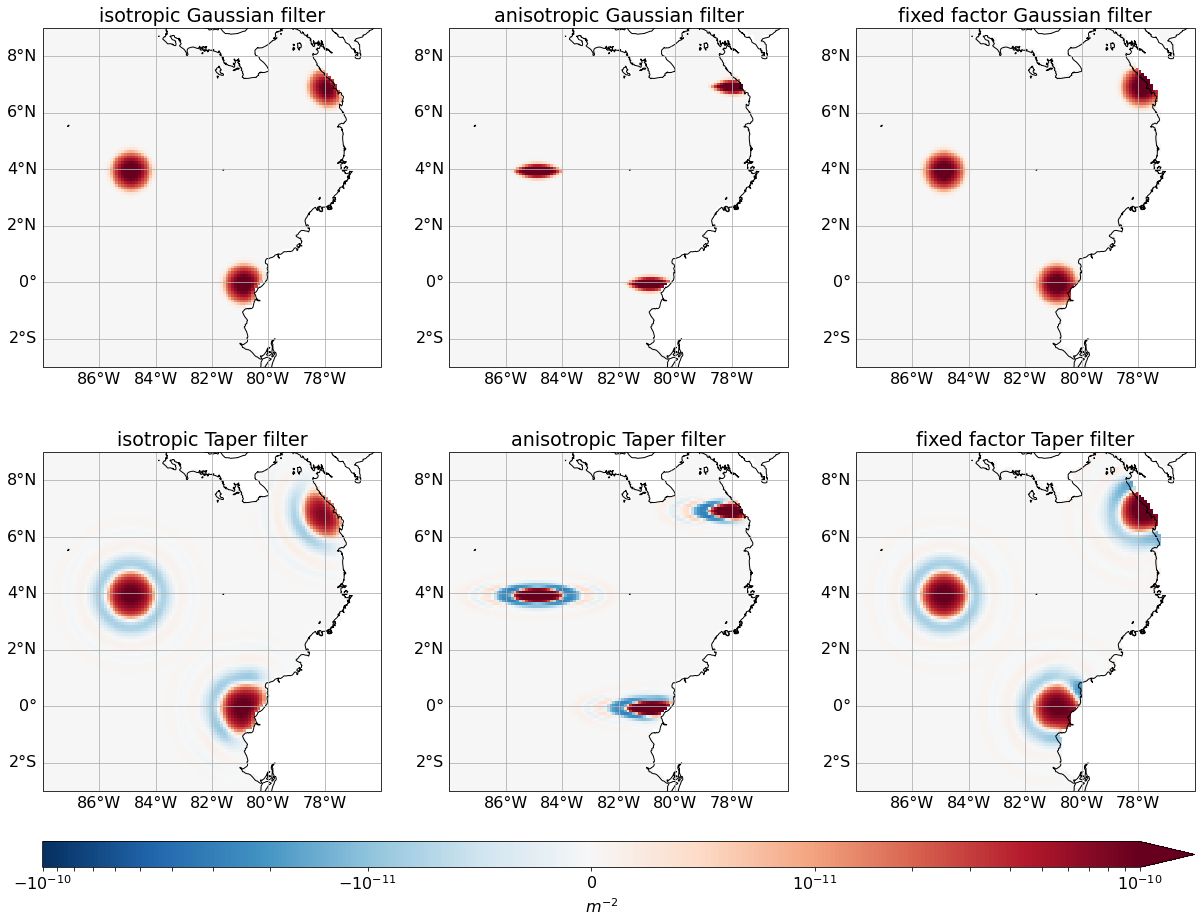

In [31]:
# Tropical Pacific
nlon0_tp = 0
nlon1_tp = 1000
nlat0_tp = 1100
nlat1_tp = 1300
xslice = slice(nlon0_tp,nlon1_tp)
yslice = slice(nlat0_tp,nlat1_tp)

fig,axs = plt.subplots(2,3,figsize=(20,12),subplot_kw={'projection':ccrs.PlateCarree()})
        
((delta4_filtered_Gaussian_isotropic+delta5_filtered_Gaussian_isotropic+delta6_filtered_Gaussian_isotropic)/tarea).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0,0],x='ULONG',y='ULAT',
                                                                     vmin=-1e-10,vmax=1e-10,cmap='RdBu_r',
                                                                     norm=mpl.colors.SymLogNorm(linthresh=1e-11),
                                                                     add_colorbar=False,
                                                                     transform=ccrs.PlateCarree())

((delta4_filtered_Gaussian_anisotropic+delta5_filtered_Gaussian_anisotropic+delta6_filtered_Gaussian_anisotropic)/tarea).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0,1],x='ULONG',y='ULAT',
                                                                                vmin=-1e-10,vmax=1e-10,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=1e-11),
                                                                                 add_colorbar=False,
                                                                                 transform=ccrs.PlateCarree())
                                                                               
((delta4_filtered_Taper_isotropic+delta5_filtered_Taper_isotropic+delta6_filtered_Taper_isotropic)/tarea).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1,0],x='ULONG',y='ULAT',                                                                                                  
                                                                                vmin=-1e-10,vmax=1e-10,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=1e-11),
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())

((delta4_filtered_Taper_anisotropic+delta5_filtered_Taper_anisotropic+delta6_filtered_Taper_anisotropic)/tarea).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1,1],x='ULONG',y='ULAT',
                                                                                vmin=-1e-10,vmax=1e-10,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=1e-11),
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())

((delta4_filtered_fixed_factor_Gaussian+delta5_filtered_fixed_factor_Gaussian+delta6_filtered_fixed_factor_Gaussian)/tarea).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0,2],x='ULONG',y='ULAT',
                                                                                vmin=-1e-10,vmax=1e-10,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=1e-11),
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())

p=((delta4_filtered_fixed_factor_Taper+delta5_filtered_fixed_factor_Taper+delta6_filtered_fixed_factor_Taper)/tarea).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1,2],x='ULONG',y='ULAT',
                                                                                vmin=-1e-10,vmax=1e-10,cmap='RdBu_r',
                                                                                norm=mpl.colors.SymLogNorm(linthresh=1e-11),
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())


for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent([-88, -76, -3, 9], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-86,-84,-82,-80,-78])
    gl.ylocator = mticker.FixedLocator([-2,0,2,4,6,8])
    
axs[0,0].set(title='isotropic Gaussian filter')
axs[0,1].set(title='anisotropic Gaussian filter')
axs[1,0].set(title='isotropic Taper filter')
axs[1,1].set(title='anisotropic Taper filter')
axs[0,2].set(title='fixed factor Gaussian filter')
axs[1,2].set(title='fixed factor Taper filter')
# colorbar
fig.subplots_adjust(left=0.1, bottom=-0.02)
cax = fig.add_axes([0.1, -0.1, 0.8, 0.03])
cbar = fig.colorbar(p, cax=cax, orientation='horizontal',extend='max')
cbar.set_label(label=r'$m^{-2}$', horizontalalignment='right')
    
plt.savefig('figures/effective_kernel_scale_112km_fac_10_tropPac_log_divided_by_area.png',dpi=400,bbox_inches='tight',pad_inches=0)